# Theorie

# Hilfsfunktionen

In [1]:
function DevMatrix(yweight, nx, ny)
    
    Wy = zeros(nx*(ny-1), nx*ny)
    Wx = zeros(nx*(ny-1), nx*ny)
    
    for i = 1:nx*(ny-1)
        Wy[i, i] = -1
        Wy[i, i+nx] = +1
    end
    
    Wy = Wy .* yweight
    
    
    ind = 0
    for iy = 1:ny
        for ix = 1:nx-1
            ind += 1  
            i = (iy-1)*nx + ix
            Wx[ind, i] = -1
            Wx[ind, i+1] = +1
        end
    end
    
    W = vcat(Wx, Wy)
       
    return W
    
end

DevMatrix (generic function with 1 method)

## TSVD

In [99]:
function TSVD(sv, p, d, err)
    
    f = zeros(length(sv.S))
    #slow = zeros(10*11)
    
    #f = zeros(d,1)
    UTd = transpose(sv.U) * (d ./ err)
    
    #for i in 1:p
        f[1:p] .= 1.0
        slow = sv.V * (f ./ sv.S .* UTd)
    #end
    
    return slow
    
end 

TSVD (generic function with 1 method)

In [47]:
function chiSquare(sv, i, pMax, d, G, W, model, error)
    
    #pMax = rank(G)
    

#chi, modelNorm, residualNorm,  = chiSquare(pMax, d, G, error)

f = zeros(length(sv.S))
modelNorm = zeros(pMax)
residualNorm = zeros(pMax)
residual = zeros(pMax)
chi = zeros(pMax)
    
    UTd = transpose(sD.U) * (d ./ error)
    
#for p in 1:pMax
    #f[p] = 1.0  # increasingly set f to one
    #model = sv.V * (f ./ sv.S .* UTd)
    #model = TSVD(sv, p, d, error)
    modelNorm[i] = norm(W * model)
    residual = (G * model - d) ./ error
    residualNorm[i] = norm(residual)
    chi[i] = sum(residual.^2) / length(d)
#end
        
    #return chi, residualNorm, modelNorm, residual
    return chi[i], modelNorm[i], residualNorm[i], residual[i]
end

chiSquare (generic function with 2 methods)

In [17]:
function Occam(G, W, lambda, d, error)
    
    GT = transpose(G)
    GTd = GT * (d ./ error)
    WTWl = transpose(W) * W .* lambda^2
    model = inv(GT * G + WTWl) * GTd
    
    return model
    
end 

Occam (generic function with 1 method)

In [32]:
function WyllieModel(v_a, v_w, v_m, por, sat, nx, ny)
    
    V_a = zeros(nx, ny) 
    V_a[1:2,:] .= v_a
    V_w = zeros(nx, ny) 
    V_w[3:5,:] .= v_w
    V_m = zeros(nx, ny) 
    V_m[6:end,:] .= v_m
        
    slow = zeros(nx, ny) 
    slow[6:end,:] = (1 - por) * (1 ./ V_m[6:end,:]) #+ ((por * sat) * (1 ./ V_w)) + ((sat * (1 - por)) * (1 ./ V_a))
    slow[3:5,:] = ((por * sat) * (1 ./ V_w[3:5,:]))
    slow[1:2,:] = ((sat * (1 - por)) * (1 ./ V_a[1:2,:]))
      
    return slow
end

WyllieModel (generic function with 1 method)

In [3]:
# Grid
x = 0:10;
y = 0:11;

In [4]:
using DelimitedFiles
using SparseArrays
IJV = readdlm("jacobian.ijv")
J = sparse(IJV[:, 1].+1, IJV[:, 2].+1, IJV[:, 3]);

In [5]:
using PyPlot
G = Matrix(J)  
size(G)

(100, 110)

In [6]:
nx = length(x) - 1
ny = length(y) - 1
function showModel(model, fixclim=true)
    matshow(transpose(reshape(model, nx, ny)))
    if fixclim
       clim(1 / 340, 1 / 2500)
        #clim(5, 25)
        set_cmap("Spectral_r")
    end
    colorbar();
    return
end

showModel (generic function with 2 methods)

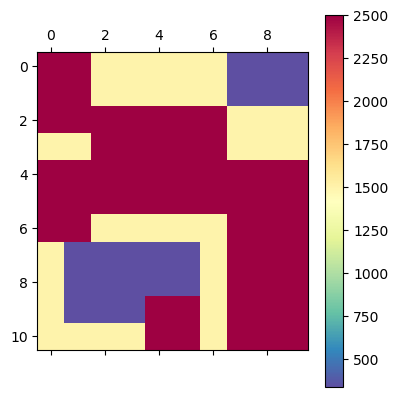

In [36]:
# velocity distribution
v_a = 340
v_w = 1500
v_m = 2500
velocity = ones(nx, ny) * v_w
velocity[2:4,8:10] .= v_a
velocity[8:10,1:2] .= v_a
velocity[5:6,8:9] .= v_a
velocity[1:2,1:3] .= v_m
velocity[3:7,3:6] .= v_m
velocity[8:10,5:11] .= v_m
velocity[1:2,5:7] .= v_m
velocity[5:6,10:11] .= v_m
showModel(velocity[:],false)

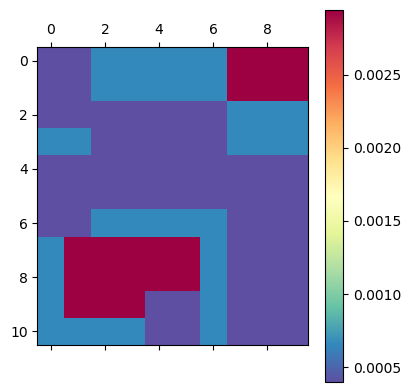

In [37]:
#por = 0.7
#sat = 0.75

slowsyn = 1 ./ velocity
#WyllieModel(v_a, v_w, v_m, por, sat, nx, ny);

showModel(slowsyn[:])

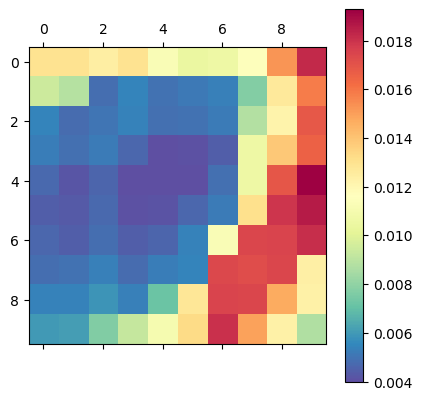

(100,)

In [38]:
d = G * slowsyn[:]
matshow(reshape(d, nx, nx))
colorbar();
size(d)

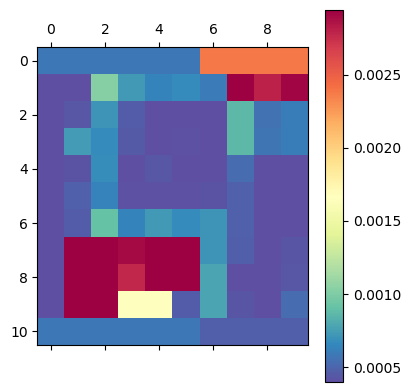

In [39]:
using LinearAlgebra
errmodel = ones(size(d)) * 0.00005
error = 1
d1 = d + (errmodel * error)
showModel(pinv(G) * d1)

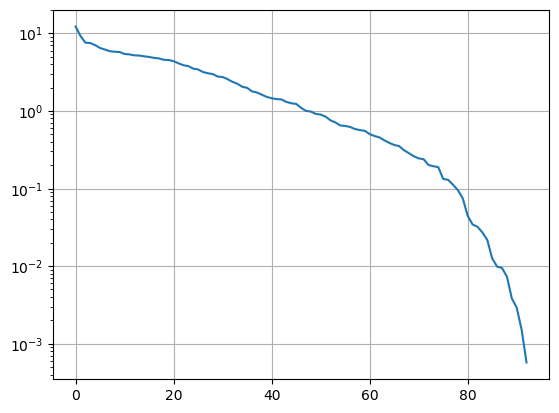

Rank: 93 s[1]: 12.256104420332287 s[r]: 0.0005724840682209178

In [40]:
s = svd(G)
r = rank(G)
print("Rank: ", r, " s[1]: ", s.S[1], " s[r]: ", s.S[r])
semilogy(s.S[1:r])
grid()
#using LinearAlgebra
#sv = svd(G)
#r = rank(G)
#weight = 3
#lambda = 10 .^ range(-2, 2, step=0.1); # lambda vector
#r

In [41]:
GD = (1.0 ./ errmodel) .* G
sD = svd(GD);

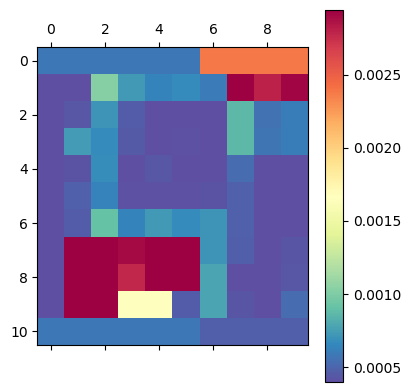

In [69]:
slow = TSVD(sD, r, d1, errmodel)
showModel(slow)

## ChiSquare

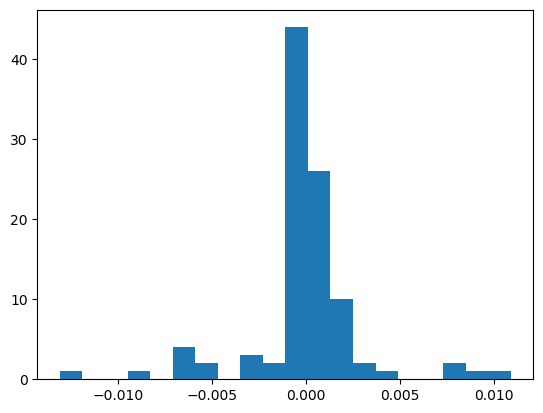

mean=-8.934885822008132e-6 std=0.0030041731783545184 norm=0.029891279251437024

In [70]:
#chi, residualNorm, modelNorm, residual = chiSquare(r, d1, G, errmodel, slow);
#modelNorm, residual = chiSquare(r, d1, G, errmodel);
using Statistics

chi, modelNorm, residualNorm, residual  = chiSquare(sD, r, d1, G, errmodel)

print("mean=", mean(residual), " std=", std(residual), " norm=", norm(residual))
hist(residual, bins=20);

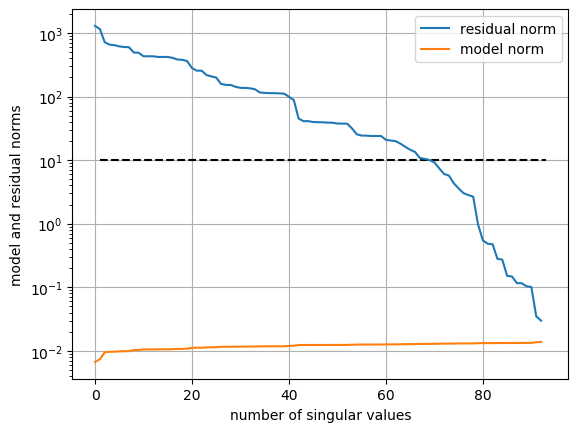

In [71]:
semilogy(residualNorm, label="residual norm")
semilogy(modelNorm, label="model norm")
hlines(sqrt(length(d1)), 1, r, linestyles="dashed")
grid()
xlabel("number of singular values")
ylabel("model and residual norms")
legend();

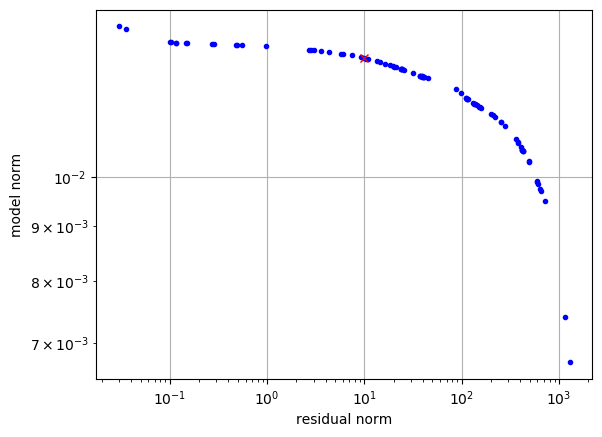

Optimum p after discrepancy principle: 70

In [72]:
pp = argmin(abs.(chi .- 1))
print("Optimum p after discrepancy principle: ", pp)
loglog(residualNorm, modelNorm, "b.")
loglog(residualNorm[pp], modelNorm[pp], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

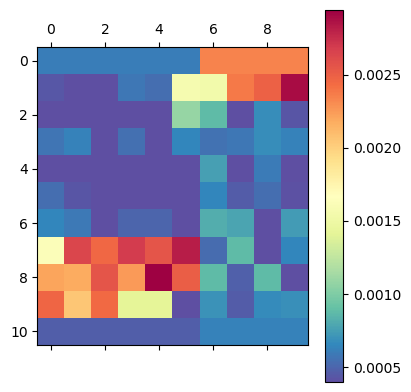

In [73]:
slow = TSVD(sD, pp, d1, errmodel)

showModel(slow)

## Occam

In [42]:
W = DevMatrix(0.7, nx, ny)

200×110 Array{Float64,2}:
 -1.0   1.0   0.0   0.0   0.0   0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  -1.0   1.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0  -1.0   1.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0  -1.0   1.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0  -1.0   1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  -1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  ⋮         

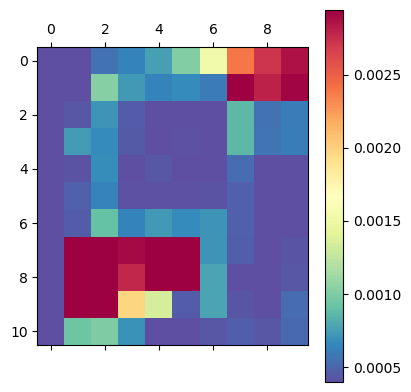

In [43]:
lambda = 0.1
slow = Occam(GD, W, lambda, d1, errmodel)
showModel(slow)

In [64]:
#lambda = 0.1
#slow = Occam(GD, W, lambda, d1, errmodel)
#showModel(slow)

lambdaVector = 10 .^ range(-3, 2, step=0.1)  # log-equdist from 0.01 to +2

n = length(lambdaVector)

slow = zeros(110)
modelNorm = zeros(n)
residualNorm = zeros(n)
residual = zeros(n)
chi = zeros(n)

for i in 1:n
    
    lambda = lambdaVector[i]
    slow = Occam(GD, W, lambda, d1, errmodel)
    
    chi[i], modelNorm[i], residualNorm[i], residual[i] = chiSquare(sD, i, n, d1, G, W, slow, errmodel)
       
end

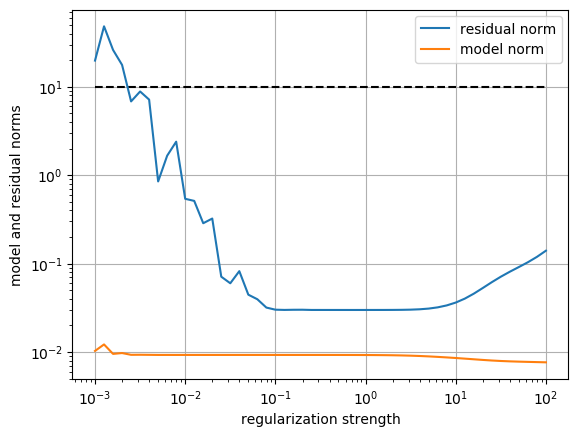

In [65]:
loglog(lambdaVector, residualNorm, label="residual norm")
loglog(lambdaVector, modelNorm, label="model norm")
hlines(sqrt(length(d1)), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

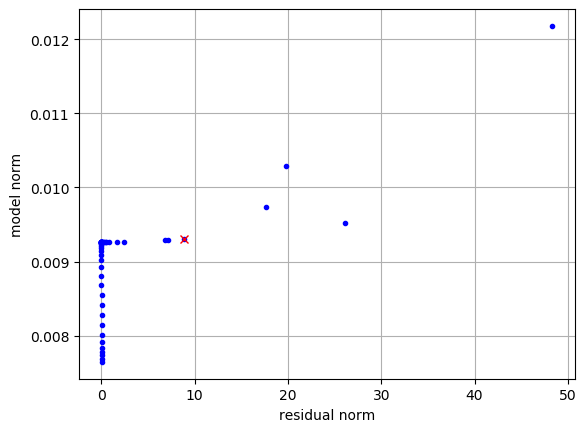

Optimum lambda after discrepancy principle: 0.0031622776601683794

In [66]:
pp = argmin(abs.(chi .- 1))
print("Optimum lambda after discrepancy principle: ", lambdaVector[pp])
plot(residualNorm, modelNorm, "b.")
plot(residualNorm[pp], modelNorm[pp], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

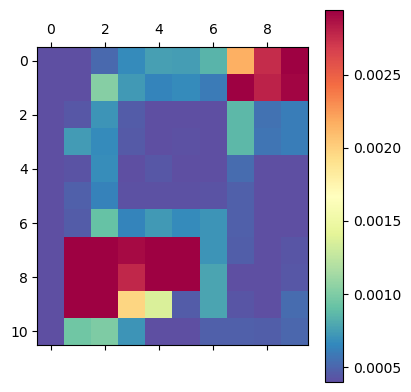

In [67]:
lambda = 0.0031622776601683794  # 10, 1, 0.1
slow = Occam(GD, W, lambda, d1, errmodel) 
showModel(slow)

## Test

In [270]:
#slow = TSVD(sv, r, d1, errmodel)

#showModel(slow[:], false)

In [271]:
#chi, p = chiSquare(r, d1, G, slow, errmodel);

#semilogy(chi)
#p

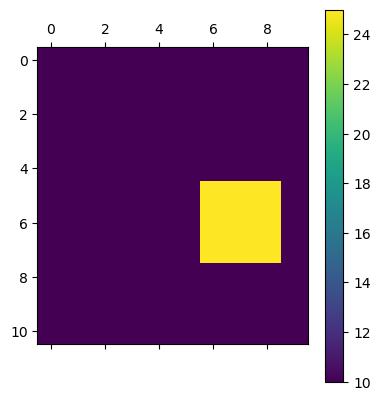

In [7]:
modelSyn = ones(nx, ny) * 10  # homogeneous
#for i = 1:10
#   modelSyn[3:5, 4:6] .= 0+()  # anomaly
modelSyn[7:9, 6:8] .= 25 
showModel(modelSyn[:],false)

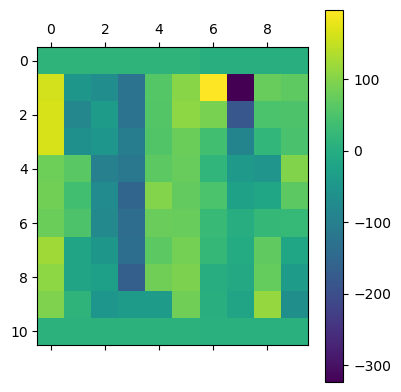

In [8]:
# Next we create synthetic data with some random noise
using LinearAlgebra
d = G * modelSyn[:]
error = 1
d += randn(size(d)) * error;  # try also 0.3, 1, 3, 10
showModel(pinv(G) * d, false)

Rank: 93 s[1]: 12.256104420332287

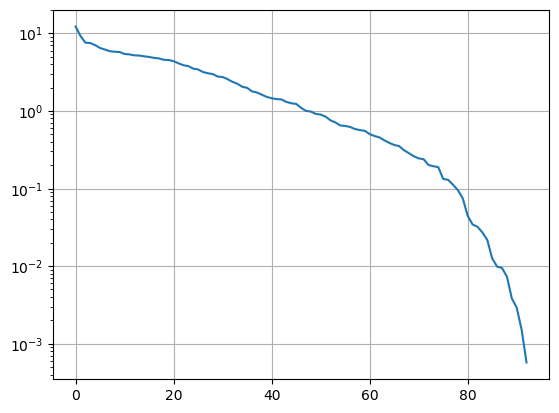

 s[r]: 0.0005724840682209178

In [9]:
s = svd(G)
r = rank(G)
print("Rank: ", r, " s[1]: ", s.S[1], " s[r]: ", s.S[r])
semilogy(s.S[1:r])
grid()

In [10]:
# The synthetic model (for easier playing with noise)
d = G * modelSyn[:]
error = 1.0  # try 0.1, 0.3, 1, 3, 10
d += randn(size(d)) * error  # add Gaussian random noise
GD = (1.0 ./ error) .* G
sD = svd(GD)
print("max(s) unscaled: ", maximum(s.S), ", scaled: ", maximum(sD.S))
# We choose the method of filter factors setting them to one or zero instead of cutting U/V
UTd = transpose(sD.U) * (d ./ error);  # U^T * d

max(s) unscaled: 12.256104420332287, scaled: 12.256104420332287

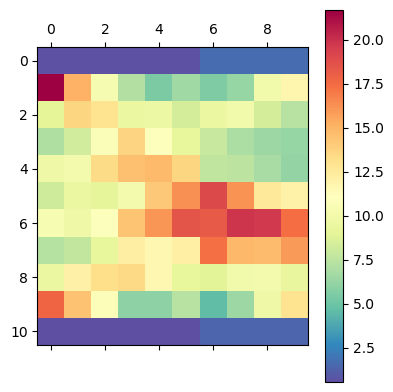

In [88]:
p = 20
f = zeros(size(sD.S))
f[1:p] .= 1.0
model = sD.V * (f ./ sD.S .* UTd)
showModel(model,false)

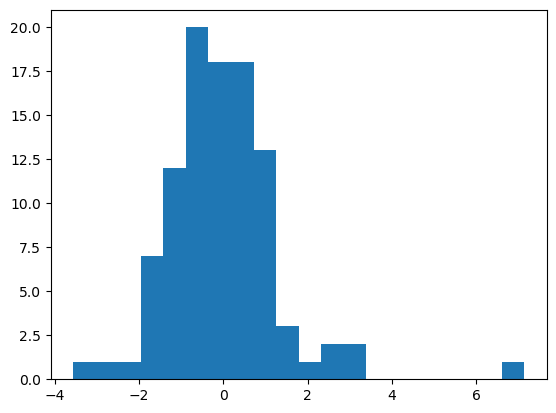

mean=-0.010888779406145375 std=1.3533881758546609 norm=13.466482556758205

110-element Array{Float64,1}:
  8.991073017920552
  8.991073017920542
  8.991073017920522
  8.991073017920538
  8.991073017920558
  8.991073017920545
 10.853735737915713
 10.853735737915708
 10.853735737915708
 10.85373573791571
 12.999202559435025
 12.75384916143026
 11.431283045546373
  ⋮
  9.15547839849021
  7.697576737894307
  8.032259699822715
  8.032259699822715
  8.032259699822715
  8.032259699822715
  8.032259699822715
  8.032259699822715
 11.236193794528262
 11.23619379452826
 11.23619379452826
 11.236193794528258

In [89]:
using Statistics
f = zeros(length(s.S))
p = 50
f[1:p] .= 1.0  # increasingly set f to one
model = TSVD(sD, p, d, error)
#model = sD.V * (f ./ sD.S .* UTd)
residual = (G * model .- d) ./ error
print("mean=", mean(residual), " std=", std(residual), " norm=", norm(residual))
hist(residual, bins=20);
model

## Chi-Test

In [11]:
pMax = rank(G)

GD = (1.0 ./ error) .* G
sD = svd(GD)

chi, modelNorm, residualNorm, residual  = chiSquare(sD, pMax, d, G, error)

print("mean=", mean(residual), " std=", std(residual), " norm=", norm(residual))
hist(residual, bins=20);

#slow, sv = TSVD(sD, pMax, d, error)


#f = zeros(length(s.S))
#modelNorm = zeros(pMax)
#residualNorm = zeros(pMax)
#chi = zeros(pMax)
#for p in 1:pMax
#    f[p] = 1.0  # increasingly set f to one
#    model = sD.V * (f ./ sD.S .* UTd)
#    modelNorm[p] = norm(model)
#    residual = (G * model - d) ./ error
#    residualNorm[p] = norm(residual)
#    chi[p] = sum(residual.^2) / length(d)
#end

MethodError: MethodError: no method matching chiSquare(::SVD{Float64,Float64,Array{Float64,2}}, ::Int64, ::Array{Float64,1}, ::Array{Float64,2}, ::Float64)
Closest candidates are:
  chiSquare(::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any) at In[2]:8

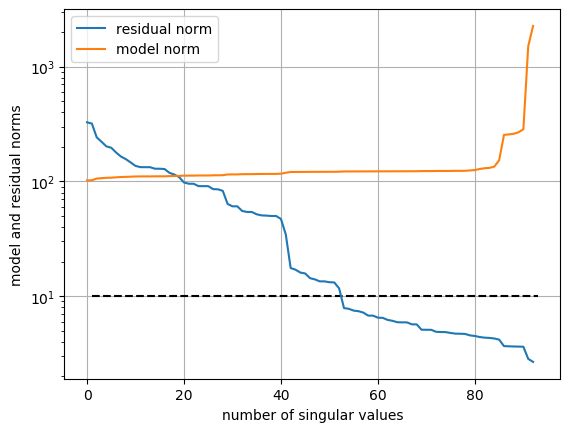

In [91]:
semilogy(residualNorm, label="residual norm")
semilogy(modelNorm, label="model norm")
hlines(sqrt(length(d)), 1, pMax, linestyles="dashed")
grid()
xlabel("number of singular values")
ylabel("model and residual norms")
legend();

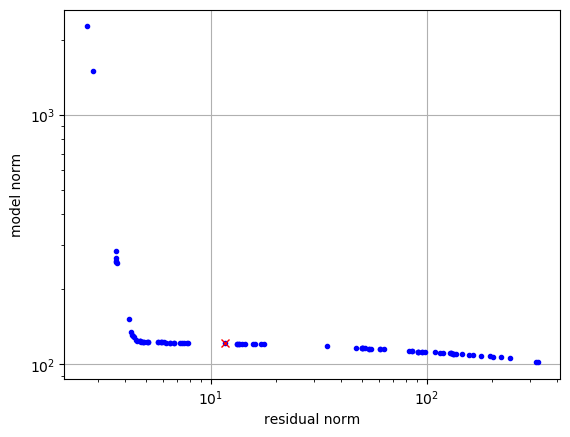

Optimum p after discrepancy principle: 53

In [92]:
pp = argmin(abs.(chi .- 1))
print("Optimum p after discrepancy principle: ", pp)
loglog(residualNorm, modelNorm, "b.")
loglog(residualNorm[pp], modelNorm[pp], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

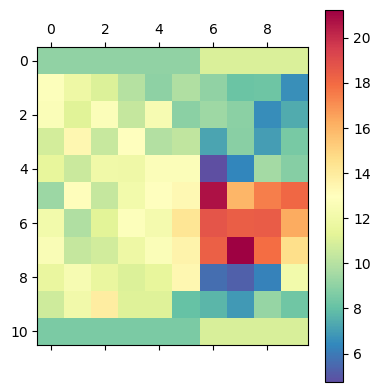

In [94]:
slow = TSVD(sD, pp, d, error)

showModel(slow, false)

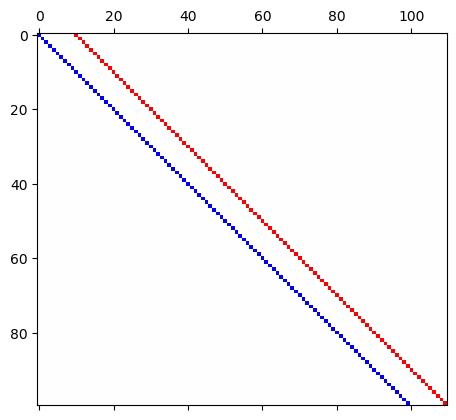

In [13]:
Cy = zeros(nx*(ny-1), nx*ny)
for i = 1:nx*(ny-1)
    Cy[i, i] = -1
    Cy[i, i+nx] = +1
end
matshow(Cy)
set_cmap("bwr")

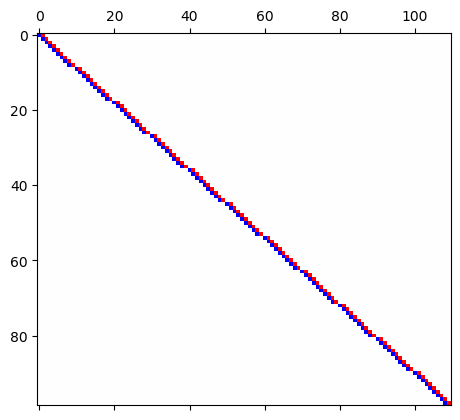

In [14]:
# now all x directed boundaries
Cx = zeros((nx-1)*ny, nx*ny)
ind = 0
for iy = 1:ny
    for ix = 1:nx-1
        ind += 1  # count upwards
        i = (iy-1)*nx + ix
        Cx[ind, i] = -1
        Cx[ind, i+1] = +1
    end
end
matshow(Cx)
set_cmap("bwr")

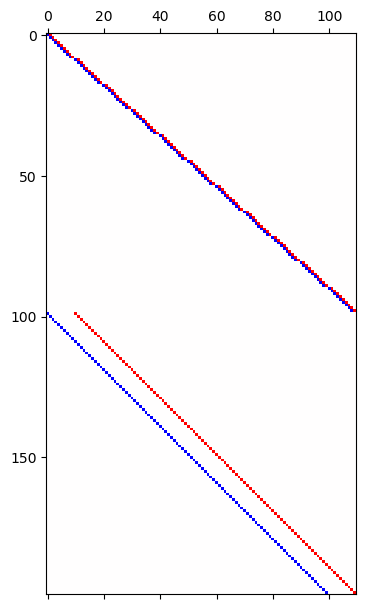

In [15]:
C = vcat(Cx, Cy)
matshow(C)
set_cmap("bwr")

## Lambda-Test

In [29]:
lambdaVector = 10 .^ range(-2, 2, step=0.1)  # log-equdist from 0.01 to +2
GD = (1.0 ./ error) .* G
sD = svd(GD)

n = length(lambdaVector)

slow = zeros(110)
modelNorm = zeros(n)
residualNorm = zeros(n)
residual = zeros(n)
chi = zeros(n)

for i in 1:length(lambdaVector)
    
    lambda = lambdaVector[i]
    slow = Occam(GD, C, lambda, d, error)
    
    chi[i], modelNorm[i], residualNorm[i], residual[i] = chiSquare(sD, i, length(lambdaVector), d, G, slow, error)
       
end


#modelNorm = zeros(size(lambdaVector))
#residualNorm = zeros(size(lambdaVector))
#chi = zeros(size(lambdaVector))
#GDT = transpose(GD)
#for i =  1:length(lambdaVector)
#    lambda = lambdaVector[i]
#    model = inv(GDT * GD + transpose(C) * C .* lambda^2) * (GDT * (d ./ error))
#    modelNorm[i] = norm(C * model)
#    residual = (G * model - d) ./ error
#    residualNorm[i] = norm(residual)
#    chi[i] = sum(residual.^2) / length(d)    
#end

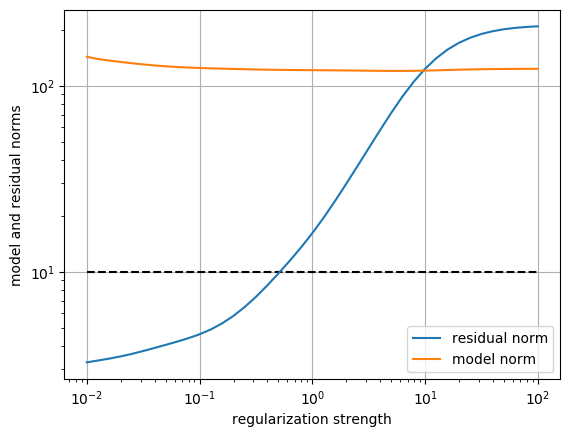

In [31]:
loglog(lambdaVector, residualNorm, label="residual norm")
loglog(lambdaVector, modelNorm, label="model norm")
#loglog(lambdaVector[pp],residualNorm[pp], "rx")
hlines(sqrt(length(d)), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

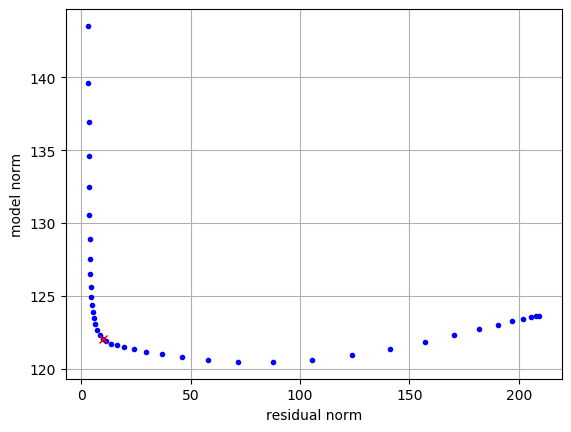

Optimum lambda after discrepancy principle: 0.5011872336272722

In [32]:
pp = argmin(abs.(chi .- 1))
print("Optimum lambda after discrepancy principle: ", lambdaVector[pp])
plot(residualNorm, modelNorm, "b.")
plot(residualNorm[pp], modelNorm[pp], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

0.9642648731343623

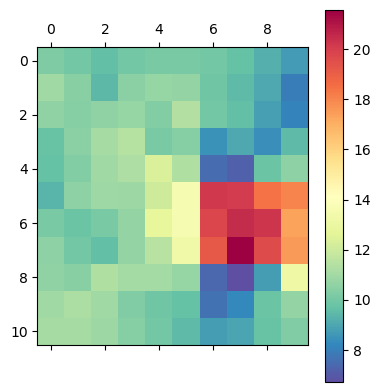

In [35]:
lambda = 0.5011872336272722  # 10, 1, 0.1
GDT = transpose(GD)
model = inv(GDT * GD + transpose(C) * C .* lambda^2) * (GDT * (d ./ error))
residual = (G * model - d) ./ error
display(sum(residual.^2) / length(d))  # 
showModel(model, false)